In [1]:
import copy
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit.primitives import BackendEstimator
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima, FakeSherbrooke, FakeLimaV2, FakeWashington
from qiskit import QuantumCircuit, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise

from functools import partial

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

D = {'output': 'mpl', 'fold': -1, 'idle_wires': False}

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [3]:
real_backend = provider.get_backend('ibm_sherbrooke')

In [4]:
fake_backend = FakeSherbrooke()

## Local
fake_backend_ideal = QasmSimulator() # Noiseless
fake_backend_noisy = AerSimulator.from_backend(fake_backend) # Noisy
stabilizer_simulator = AerSimulator(method='extended_stabilizer')

fake_run_config_ideal = {'shots': 10000, 'backend': fake_backend_ideal, 'name': 'fake_ideal'}
fake_run_config_noisy = {'shots': 10000, 'backend': fake_backend_noisy, 'name': 'fake_noisy'}

In [5]:
from qiskit.circuit import Parameter

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_98q_paper_Clifford(self):
            self['nq'] = 98
            self['h'] = 0.5*np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_98q_paper_nonClifford(self):
            self['nq'] = 98
            self['h'] = 0.66*np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_6q_paper(self):
            self['nq'] = 6
            self['h'] = np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, num_steps, measure_basis):
        ops['measure_basis'] = measure_basis
        ops['depth'] = num_steps
        qc = cls.make_quantum_circuit(ops)
        qc.metadata = {}
        qc.metadata['measure_basis'] = measure_basis
        qc.metadata['depth'] = num_steps
        return qc

In [87]:
sherbrooke_layout = list(range(113, 127)) + [112] + list(range(108, 93, -1)) + [90] + list(range(75, 90)) + [74] + list(range(70, 55, -1)) + [52] + list(range(37, 52)) + [36, 32, 31, 30, 17] + list(range(12, 3, -1)) + [15, 22, 23, 24, 25, 26]

print(len(sherbrooke_layout))

98


In [18]:
from qiskit.transpiler.passes import RemoveBarriers
def construct_ising_circuit_98q_Clifford(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_98q_paper_Clifford()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

def construct_ising_circuit_98q_nonClifford(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_98q_paper_nonClifford()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

def construct_ising_circuit_4q_nonClifford(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_4q_paper()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

In [ ]:
J = 0.15
basis = 'Z'
random_ising = construct_ising_circuit_98q_nonClifford(J, basis, 2)
# random_ising = RemoveBarriers()(random_ising)
trans_circuit = transpile(
    random_ising,
    backend=fake_backend_noisy,
    optimization_level=3,
    initial_layout=sherbrooke_layout,
)
trans_circuit.remove_final_measurements()
trans_circuit.draw(**D)

In [81]:
def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

def construct_random_ising_func(num_steps, be, num_q):
    basis = 'Z'
    if num_q == 98:
        J = np.random.uniform(0, np.pi * 0.66, size=1)[0]
        random_ising = construct_ising_circuit_98q_nonClifford(J, basis, num_steps)
    else:
        raise NotImplementedError
    trans_circuit = transpile(
        random_ising,
        backend=be,
        optimization_level=3,
        initial_layout=sherbrooke_layout,
    )
    return trans_circuit, J

def get_Js(num_Js, num_q):
    np.random.seed(42)
    if num_q == 98:
        h = np.pi * 0.66
    else:
        raise NotImplementedError
    return np.random.uniform(0, h, size=num_Js)

from pec_runtime.utils.stratify import stratify_circuit_into_layers
from pec_runtime.circuit import TwirledCircuit

def construct_random_ising_sameJ_twirled_nonCliff_func(J, be, num_q, num_steps, num_twirl=2):
    basis = 'Z'
    if num_q == 98:
        random_ising = construct_ising_circuit_98q_nonClifford(J, basis, num_steps)
    else:
        raise NotImplementedError

    random_ising.remove_final_measurements()
    layers = stratify_circuit_into_layers(random_ising, twirled_qubits=list(range(num_q)))
    twirled_body = TwirledCircuit(layers, barriers=True)
    random_ising_list = twirled_body.sample_circuits(num_samples=num_twirl)

    ranges_to_remove = [(i, i+6) for i in range(1, 100, 8)]
    random_ising_list_opt = []
    for circuit in random_ising_list:
        new_circuit = QuantumCircuit(*circuit.qregs)
        barrier_count = 0
        for op, qubits, _ in circuit.data:
            if op.name == 'barrier':
                barrier_count += 1
                if any(start <= barrier_count <= end for start, end in ranges_to_remove):
                    continue
            new_circuit.append(op, qubits)
        random_ising_list_opt.append(new_circuit)

    for i in range(len(random_ising_list_opt)):
        random_ising_list_opt[i].measure_all()

    trans_circuits = transpile(
        random_ising_list_opt,
        backend=be,
        optimization_level=3,
        initial_layout=sherbrooke_layout,
    )
    return trans_circuits, J

def construct_random_ising_sameJ_twirled_Cliff_func(be, num_q, num_steps, num_twirl=2):
    basis = 'Z'
    if num_q == 98:
        random_ising = construct_ising_circuit_98q_Clifford(0, basis, num_steps)
    else:
        raise NotImplementedError

    random_ising.remove_final_measurements()
    layers = stratify_circuit_into_layers(random_ising, twirled_qubits=list(range(num_q)))
    twirled_body = TwirledCircuit(layers, barriers=True)
    random_ising_list = twirled_body.sample_circuits(num_samples=num_twirl)

    ranges_to_remove = [(i, i+6) for i in range(1, 100, 8)]
    random_ising_list_opt = []
    for circuit in random_ising_list:
        new_circuit = QuantumCircuit(*circuit.qregs)
        barrier_count = 0
        for op, qubits, _ in circuit.data:
            if op.name == 'barrier':
                barrier_count += 1
                if any(start <= barrier_count <= end for start, end in ranges_to_remove):
                    continue
            new_circuit.append(op, qubits)
        random_ising_list_opt.append(new_circuit)

    for i in range(len(random_ising_list_opt)):
        random_ising_list_opt[i].measure_all()

    trans_circuits = transpile(
        random_ising_list_opt,
        backend=be,
        optimization_level=3,
        initial_layout=sherbrooke_layout,
    )
    return trans_circuits, J

In [73]:
trans_circuits, J = construct_random_ising_sameJ_twirled_nonCliff_func(0.1, real_backend, 98, 4)

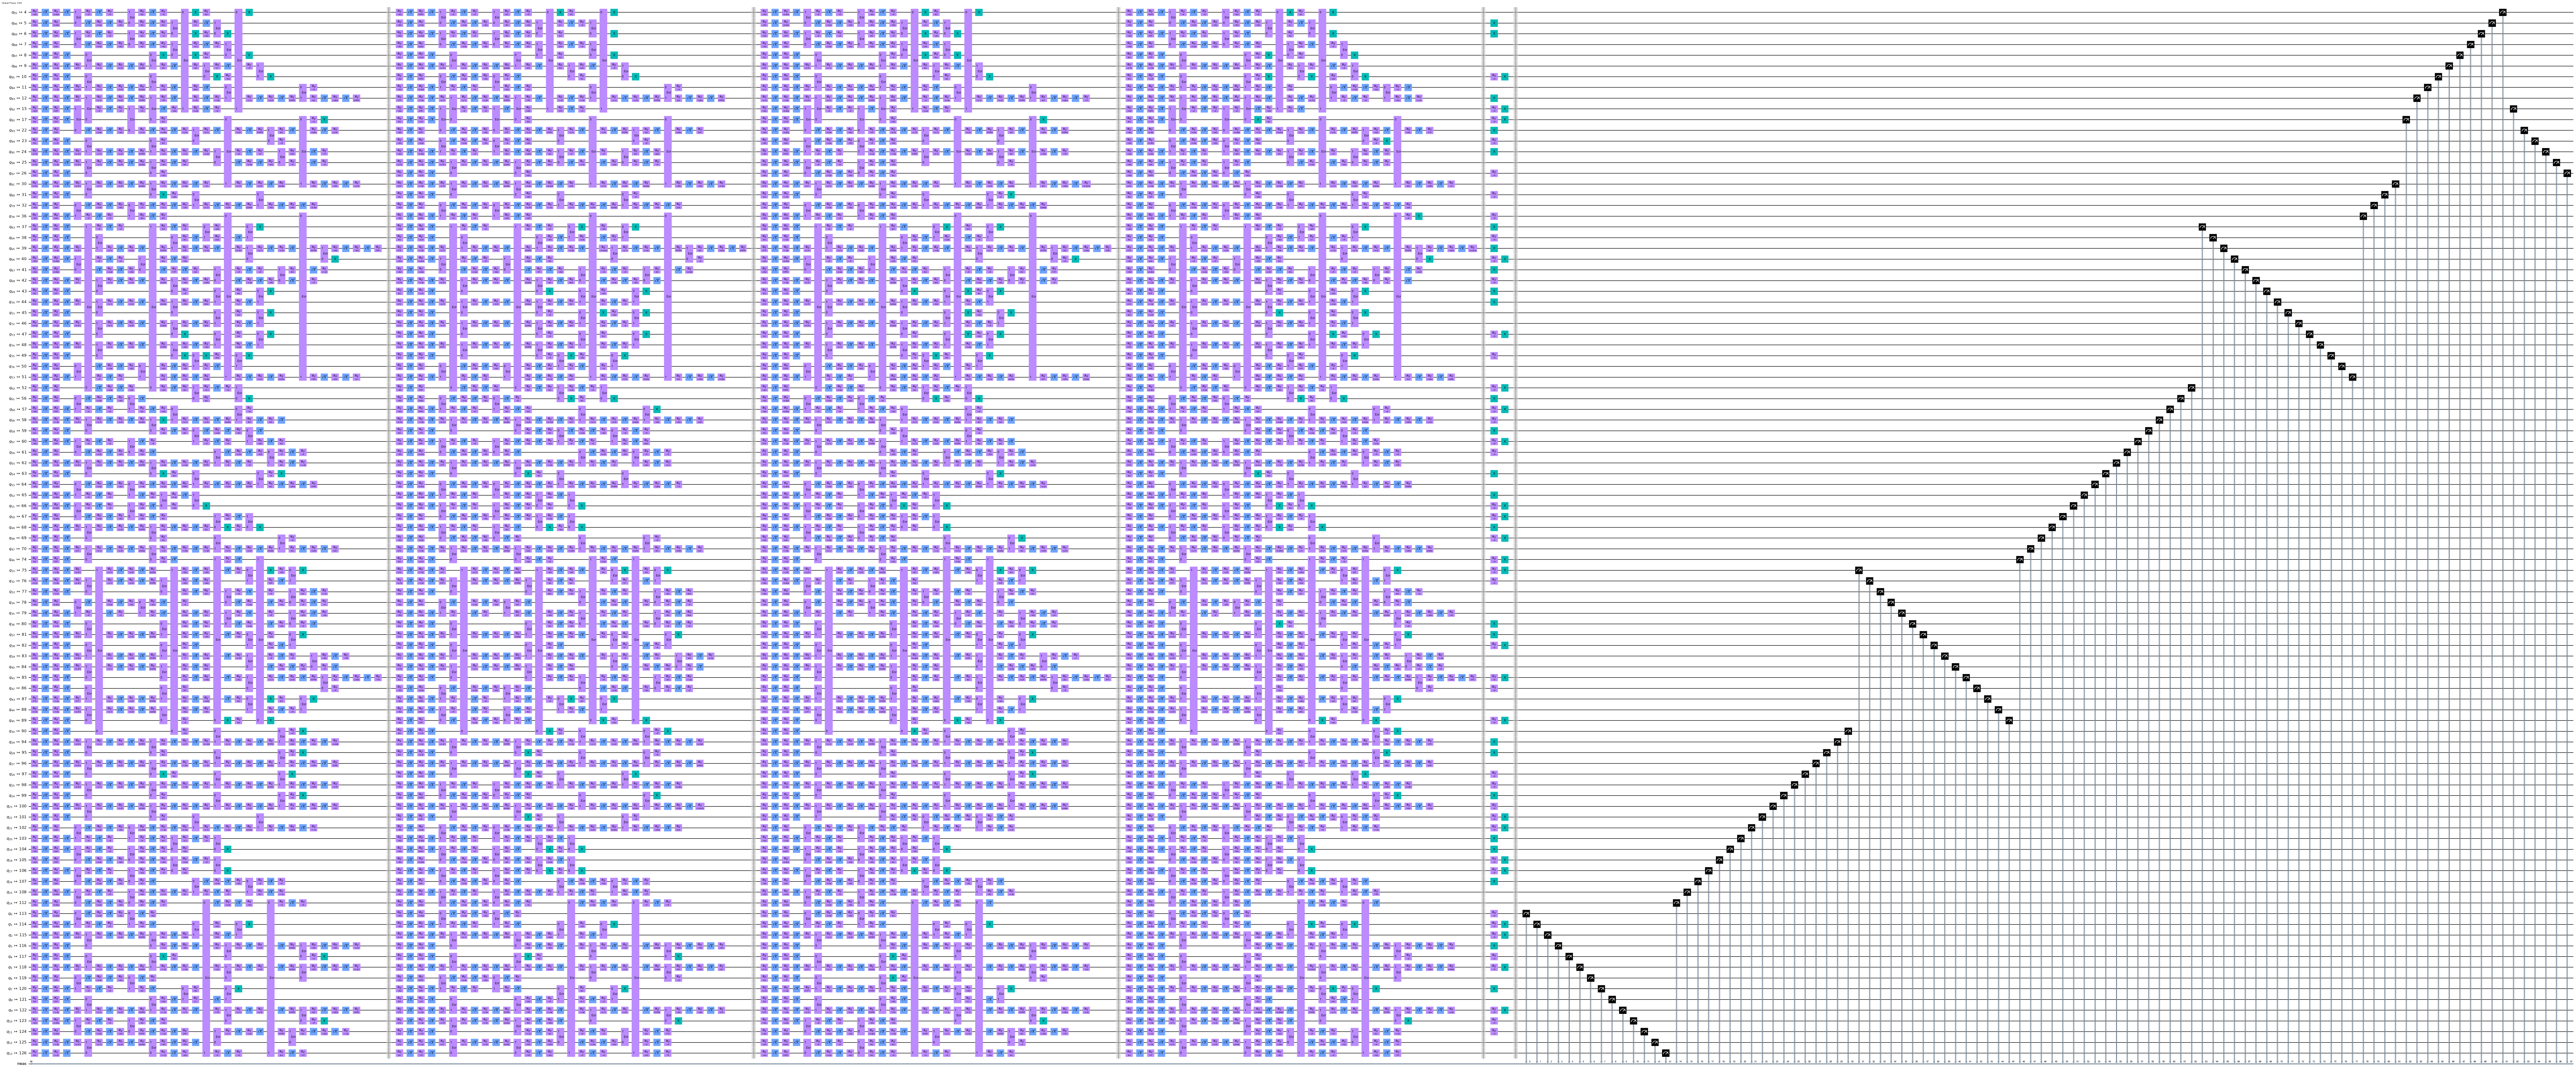

In [74]:
trans_circuits[0].draw(**D)

In [78]:
trans_circuits, J = construct_random_ising_sameJ_twirled_Cliff_func(real_backend, 98, 2)

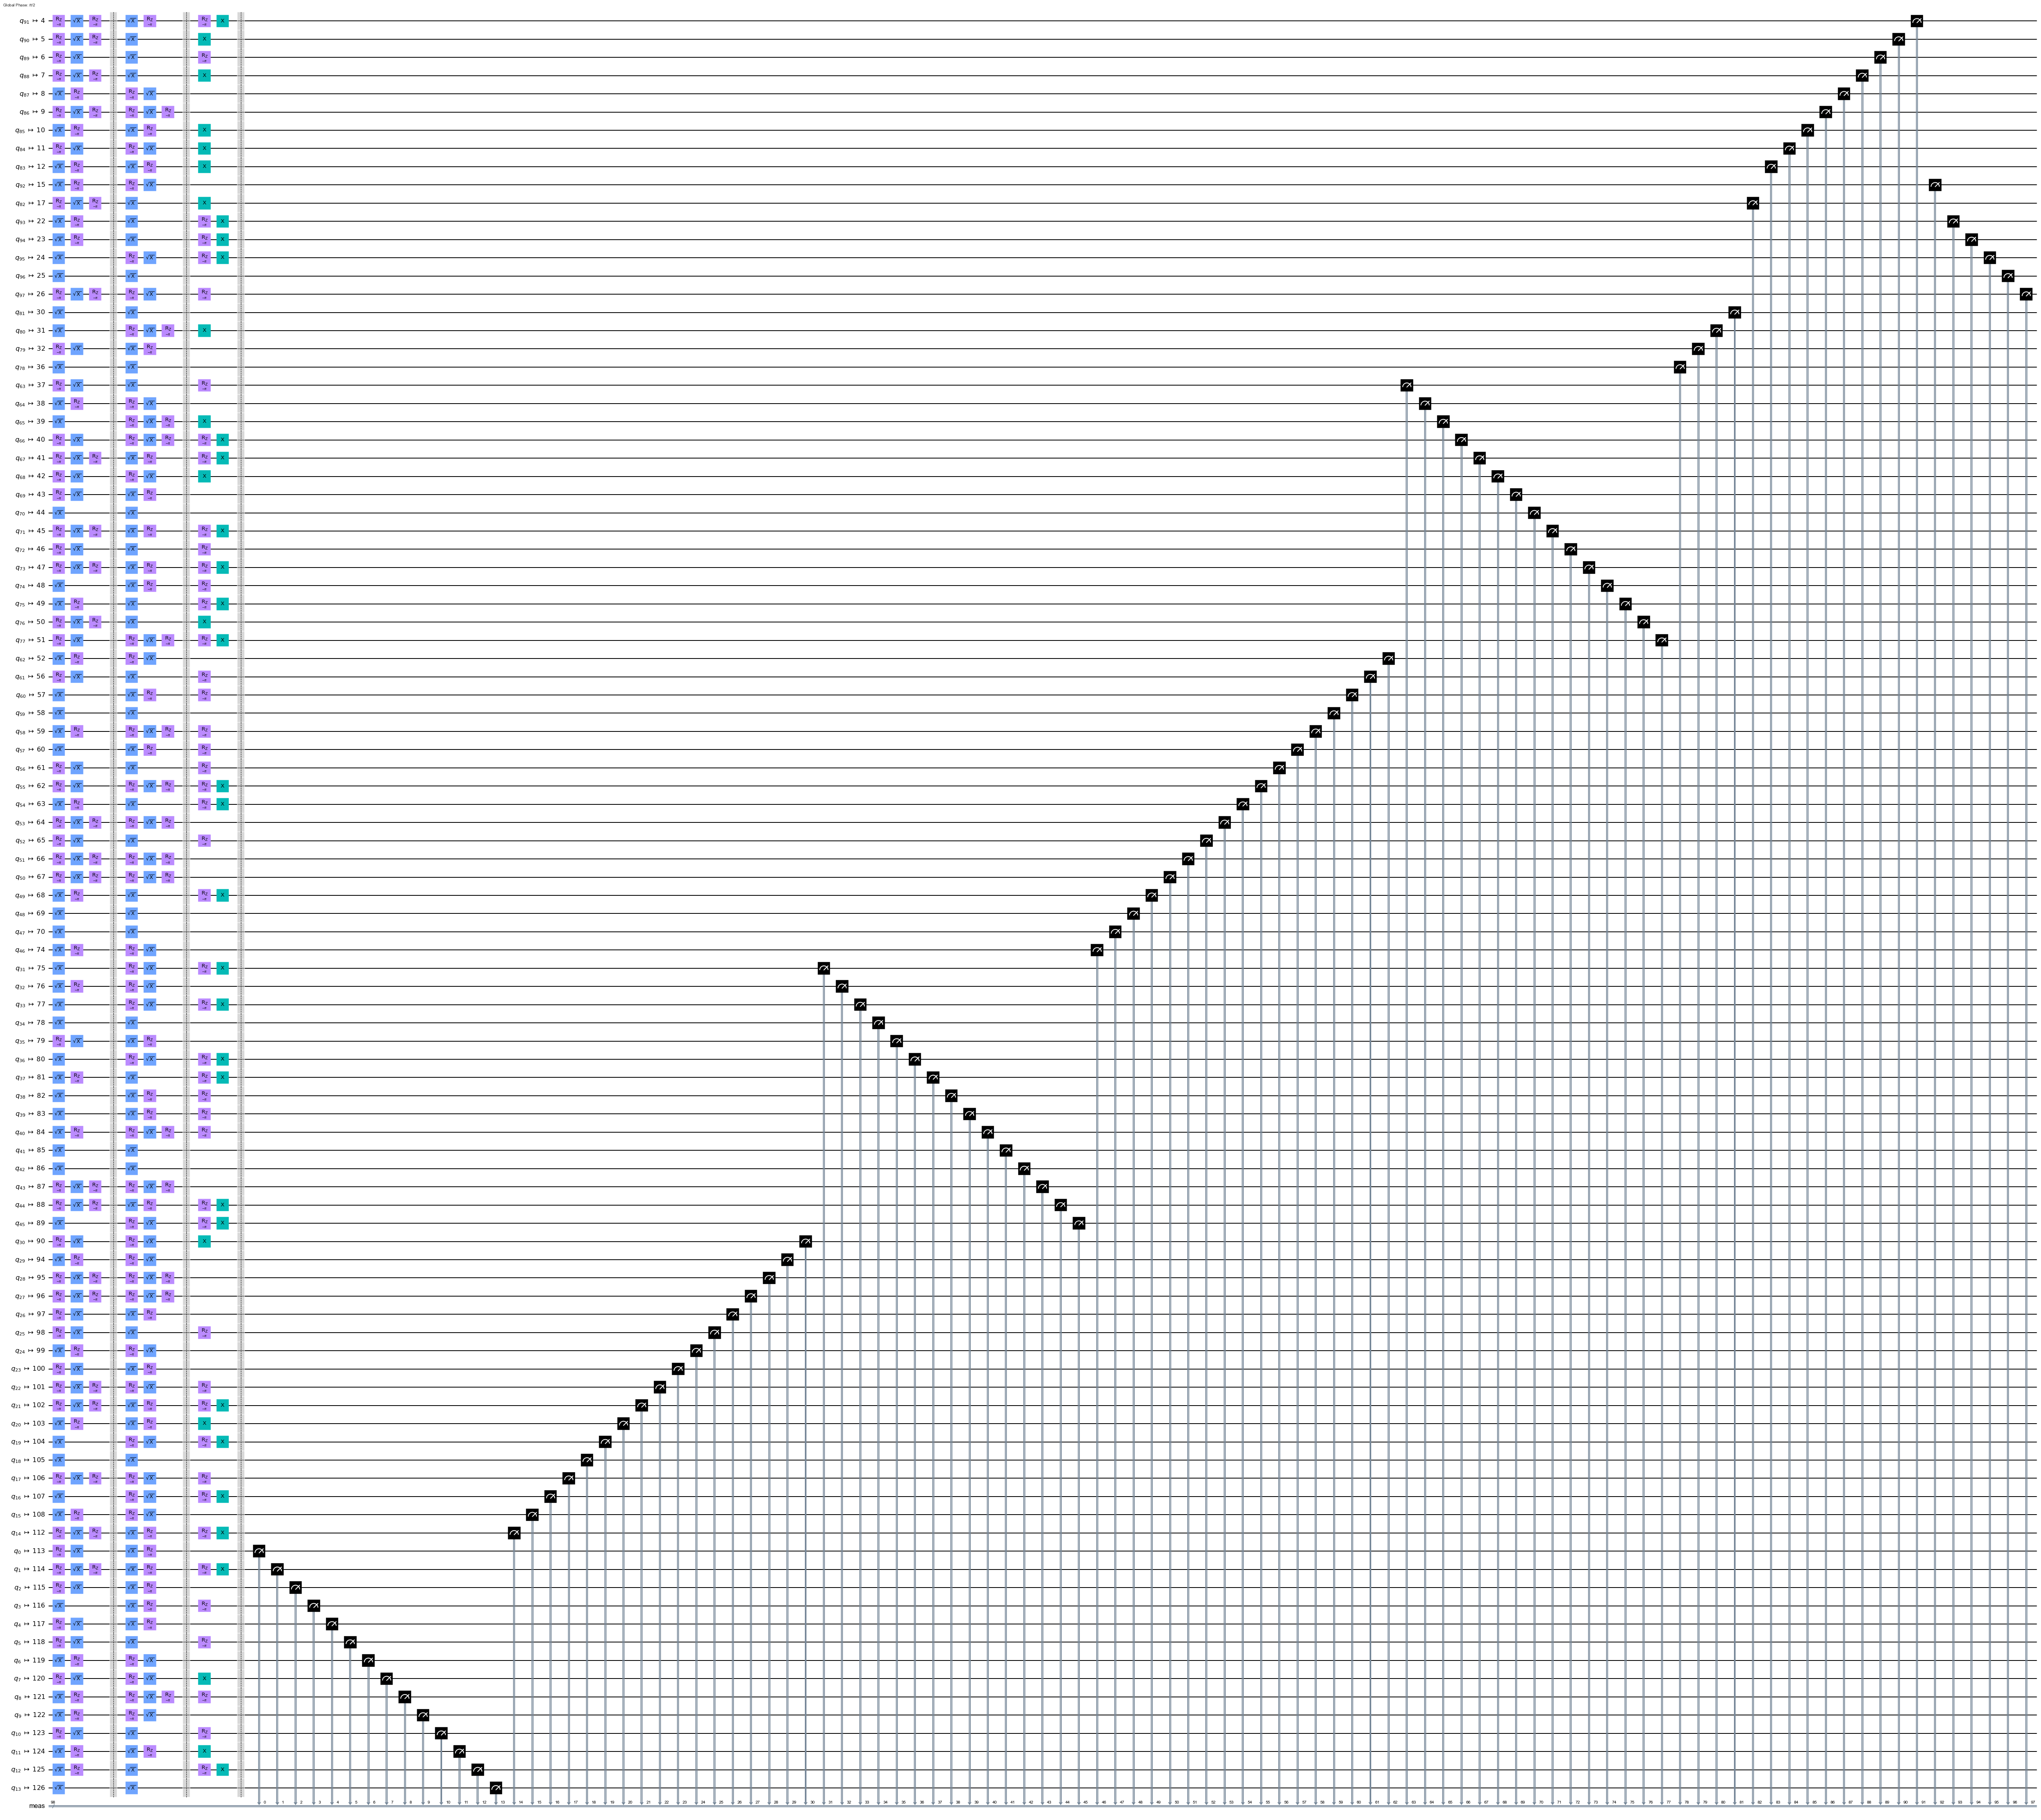

In [79]:
trans_circuits[0].draw(**D)

In [ ]:
# random_ising = construct_ising_circuit_98q_nonClifford(0.1, 'Z', 4)
# random_ising.remove_final_measurements()
# layers = stratify_circuit_into_layers(random_ising, twirled_qubits=list(range(98)))
# twirled_body = TwirledCircuit(layers, barriers=True)
# random_ising_list = twirled_body.sample_circuits(num_samples=2)
#
# print('...')
# circuit = random_ising_list[0]
# new_circuit = QuantumCircuit(*circuit.qregs)
# ranges_to_remove = [(i, i+6) for i in range(1, 100, 8)]
# barrier_count = 0
# for op, qubits, _ in circuit.data:
#     if op.name == 'barrier':
#         barrier_count += 1
#         if any(start <= barrier_count <= end for start, end in ranges_to_remove):
#             continue
#     new_circuit.append(op, qubits)
#
# # print('...')
# # new_circuit.draw(**D)
#
# print('...')
# trans_circ = transpile(
#     new_circuit,
#     backend=real_backend,
#     optimization_level=3,
#     initial_layout=sherbrooke_layout,
# )
# print('...')
# trans_circ.draw(**D)

In [85]:
from qiskit.transpiler.exceptions import TranspilerError
import scipy

def generate_data(two_q_gate_depths, save_path: str, n_Js: int, be, num_q):
    Js = get_Js(n_Js, num_q)
    for depth in two_q_gate_depths:

        trans_circuits_twirled, J = construct_random_ising_sameJ_twirled_Cliff_func(be, num_q, depth, num_twirl=5)

        entries = []
        for circuit_twirled in trans_circuits_twirled:
            to_append = dict()
            to_append['circuit_twirled'] = circuit_twirled
            to_append['steps'] = depth
            to_append['J'] = 0
            entries.append(to_append)

        path = "%s/step_%02d_J%d.pk"%(save_path, depth, 0)
        with open(path, "wb") as f:
            pickle.dump(entries, f)

        for i in tqdm_notebook(range(1, n_Js)):

            trans_circuits_twirled, J = construct_random_ising_sameJ_twirled_nonCliff_func(J=Js[i], be=be, num_q=num_q, num_steps=depth, num_twirl=5)

            entries = []
            for circuits_twirled in trans_circuits_twirled:
                to_append = dict()
                to_append['circuits_twirled'] = circuits_twirled
                to_append['steps'] = depth
                to_append['J'] = J
                entries.append(to_append)

            path = "%s/step_%02d_J%d.pk"%(save_path, depth, i)
            with open(path, "wb") as f:
                pickle.dump(entries, f)

random.seed(42)
np.random.seed(42)
steps = list(range(1, 11))
generate_data(steps,
              './data/ising_zne_hardware_twirled/98q_sherbrooke',
              50,
              real_backend,
              num_q=98)

  0%|          | 0/49 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
with open('./data/ising_zne_hardware/98q_sherbrooke_sameJ_h0.66pi/step_01.pk', 'rb') as file:
    loaded = pickle.load(file)

circ = loaded[1]['circuit']
circ.remove_final_measurements()
circ.draw(**D)

In [23]:
import os
from tqdm.notebook import tqdm
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)])
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                # ideal_exp_vals.append(entry['ideal_exp_value'])
                # noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits #, ideal_exp_vals, noisy_exp_vals

train_circuits = load_circuits('./data/ising_zne_hardware/98q_sherbrooke_sameJ_h0.66pi', '.pk')

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# train_circuits[61].remove_final_measurements()
train_circuits[1].draw(**D)

In [26]:
# obs_list = ['Z'+'I'*97, 'I'*22+'Z'+'I'*75, 'I'*44+'Z'+'I'*53, 'I'*61+'Z'+'I'*36, 'I'*78+'Z'+'I'*19]
obs_list = ['Z'+'I'*97, 'I'*20+'Z'+'I'*77, 'I'*40+'Z'+'I'*57, 'I'*50+'Z'+'I'*47, 'I'*66+'Z'+'I'*31]
padded_obs_all_circs = []
for trans_circuit in train_circuits:
    padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 98), 127)) for obs in obs_list]

In [27]:
print([126-padded_obs_all_circs[i].paulis.to_labels()[0].find('Z') for i in range(120, 125)])

[113, 101, 88, 56, 36]


In [21]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
options = Options()
options.resilience_level = 2
options.optimization_level = 0
options.execution.shots = 10000
options.resilience.noise_factors = (1, 3)
options.resilience.noise_amplifier = 'TwoQubitAmplifier'
options.resilience.extrapolator = 'LinearExtrapolator'
service = QiskitRuntimeService()

In [22]:
job_ids = []
num_circs_per_depth = 30
num_depths_per_job = 1
with Session(service=service, backend="ibm_sherbrooke") as session:
    runtime_estimator = RuntimeEstimator(session=session, options=options)
    for i in range(0, 10, num_depths_per_job):
        train_circuit_batch = train_circuits[num_circs_per_depth*i:num_circs_per_depth*(i+num_depths_per_job)]
        padded_obs_batch = padded_obs_all_circs[len(obs_list)*num_circs_per_depth*i:len(obs_list)*num_circs_per_depth*(i+num_depths_per_job)]
        assert len(train_circuit_batch) * len(obs_list) == len(padded_obs_batch)

        circ_to_submit = []
        for circ in train_circuit_batch:
            circ.remove_final_measurements()
            circ_to_submit.append(circ)

        job = runtime_estimator.run(
            circuits=np.repeat(np.array(circ_to_submit, dtype=QuantumCircuit), len(obs_list)),
            observables=padded_obs_batch
        )

        job_ids.append(job.job_id())
        print(job.job_id())
        print(len(circ_to_submit))

    with open('./data/ising_zne_hardware/98q_sherbrooke_30persteps_shots1w_sameJ_h0.66pi_third_job_ids.pk', 'wb') as file:
        pickle.dump(job_ids, file)

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_38122/2264038870.py:17: FutureWarning: The input object of type 'SXGate' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'SXGate', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  circuits=np.repeat(np.array(circ_to_submit, dtype=QuantumCircuit), len(obs_list)),


chvsv02lnlj7ii83c2fg
30
chvsv4m1o26hu30rcqr0
30
chvsv9qlnlj7ii83cab0
30
chvsvh2lnlj7ii83cgdg
30
chvsvp8ihcilpv4uih50
30
chvt030ihcilpv4uiq3g
30
chvt0dhcinbchsnknpug
30
chvt0p9cinbchsnko41g
30
chvt16u1o26hu30rek3g
30
chvt1kmkcccjrh7iq8o0
30
